In [79]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [80]:
df_train = pd.read_csv(r'training.csv')
df_test = pd.read_csv(r'test.csv')
df_valid = pd.read_csv(r'validation.csv')
df_train.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [81]:
df_train.shape

(16000, 2)

In [82]:
X_train = np.array(df_train['text'])
X_test = np.array(df_test['text'])
X_valid = np.array(df_valid['text'])

y_train = np.array(df_train['label'])
y_test = np.array(df_test['label'])
y_valid = np.array(df_valid['label'])

In [83]:
train_y = to_categorical(y_train, 6)
test_y = to_categorical(y_test, 6)
valid_y = to_categorical(y_valid, 6)

In [84]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [85]:
train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)
valid_encodings = tokenizer(list(X_valid), truncation=True, padding=True)

In [86]:
import tensorflow as tf

#Convert encodings into Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_y
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_y
))

valid_dataset = tf.data.Dataset.from_tensor_slices((
    dict(valid_encodings),
    valid_y
))

In [87]:
train_dataset

<_TensorSliceDataset element_spec=({'input_ids': TensorSpec(shape=(87,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(87,), dtype=tf.int32, name=None)}, TensorSpec(shape=(6,), dtype=tf.float32, name=None))>

In [88]:
%pip install transformers==4.18.0

In [89]:
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments

training_args = TFTrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs = 5,
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

In [90]:
training_args

TFTrainingArguments(output_dir='./results', overwrite_output_dir=False, do_train=False, do_eval=False, do_predict=False, evaluation_strategy=<IntervalStrategy.NO: 'no'>, prediction_loss_only=False, per_device_train_batch_size=8, per_device_eval_batch_size=16, per_gpu_train_batch_size=None, per_gpu_eval_batch_size=None, gradient_accumulation_steps=1, eval_accumulation_steps=None, eval_delay=0, learning_rate=5e-05, weight_decay=0.01, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5, max_steps=-1, lr_scheduler_type=<SchedulerType.LINEAR: 'linear'>, warmup_ratio=0.0, warmup_steps=500, log_level=-1, log_level_replica=-1, log_on_each_node=True, logging_dir='./logs', logging_strategy=<IntervalStrategy.STEPS: 'steps'>, logging_first_step=False, logging_steps=10, logging_nan_inf_filter=True, save_strategy=<IntervalStrategy.STEPS: 'steps'>, save_steps=500, save_total_limit=None, save_on_each_node=False, no_cuda=False, seed=42, data_seed=None, bf16=False

In [91]:
with training_args.strategy.scope():
    model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=6)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_transform', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_99']
You should probably TRAIN this model on a down-stream task to be able to use i

In [92]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5), loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])

In [93]:
history = model.fit(train_dataset.batch(32), epochs=10, validation_data=valid_dataset.batch(32), verbose = 1)

Epoch 1/10
500/500 [==============================] - 183s 297ms/step - loss: 0.4354 - accuracy: 0.8492 - val_loss: 0.1849 - val_accuracy: 0.9350
Epoch 2/10
500/500 [==============================] - 147s 293ms/step - loss: 0.1340 - accuracy: 0.9426 - val_loss: 0.1377 - val_accuracy: 0.9355
Epoch 3/10
500/500 [==============================] - 146s 293ms/step - loss: 0.0990 - accuracy: 0.9538 - val_loss: 0.1506 - val_accuracy: 0.9365
Epoch 4/10
500/500 [==============================] - 145s 291ms/step - loss: 0.0876 - accuracy: 0.9589 - val_loss: 0.1533 - val_accuracy: 0.9340
Epoch 5/10
500/500 [==============================] - 146s 291ms/step - loss: 0.0661 - accuracy: 0.9695 - val_loss: 0.1898 - val_accuracy: 0.9410
Epoch 6/10
500/500 [==============================] - 146s 292ms/step - loss: 0.0631 - accuracy: 0.9752 - val_loss: 0.2020 - val_accuracy: 0.9340
Epoch 7/10
500/500 [==============================] - 146s 291ms/step - loss: 0.0435 - accuracy: 0.9824 - val_loss: 0.1975 -

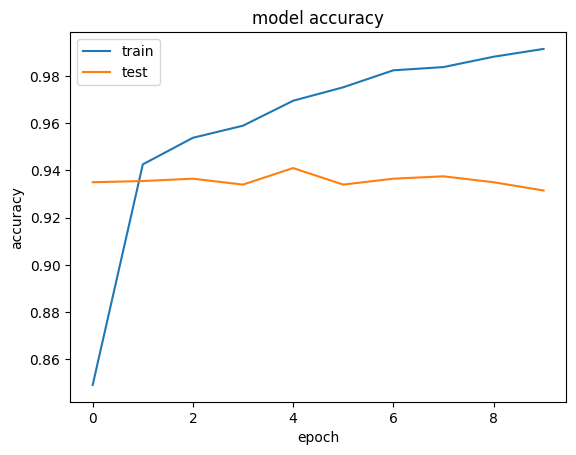

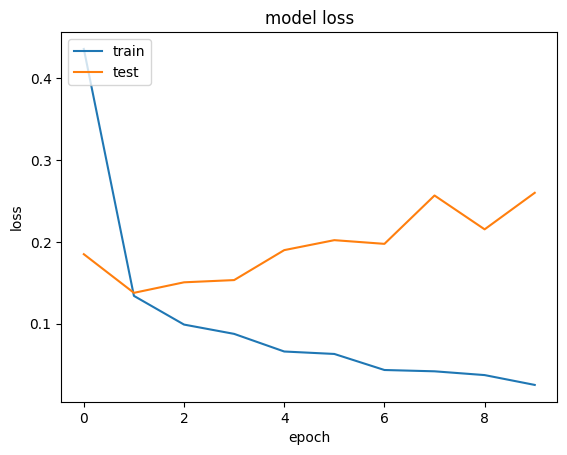

In [104]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [94]:
model.evaluate(test_dataset.batch(32))

63/63 [==============================] - 7s 77ms/step - loss: 0.2347 - accuracy: 0.9240


[0.2346743792295456, 0.9240000247955322]

In [95]:
y_pred = model.predict(test_dataset.batch(32))

63/63 [==============================] - 10s 87ms/step


In [96]:
y_pred[0]

array([[ 8.160749  , -2.6878107 , -2.5962663 , -2.1189935 , -2.365772  ,
        -2.6782403 ],
       [ 8.181448  , -2.7688758 , -2.7461362 , -1.7663771 , -2.1679418 ,
        -2.8905036 ],
       [ 8.074944  , -2.9756606 , -2.7503543 , -1.8197308 , -2.3310611 ,
        -2.540536  ],
       ...,
       [-0.9506477 ,  8.131337  , -2.448991  , -3.644003  , -2.7527213 ,
        -2.938263  ],
       [-1.1044163 ,  8.009066  , -2.154065  , -3.8452773 , -2.2040098 ,
        -3.3704977 ],
       [-0.84689975, -2.83372   , -3.130621  , -2.2745528 ,  4.4428835 ,
         1.515316  ]], dtype=float32)

In [97]:
y_pred = np.argmax(y_pred[0], axis = -1)

In [98]:
y_pred.shape

(2000,)

In [99]:
y_test.shape

(2000,)

In [100]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test, y_pred)

In [101]:
df_test.label.value_counts()

label
1    695
0    581
3    275
4    224
2    159
5     66
Name: count, dtype: int64

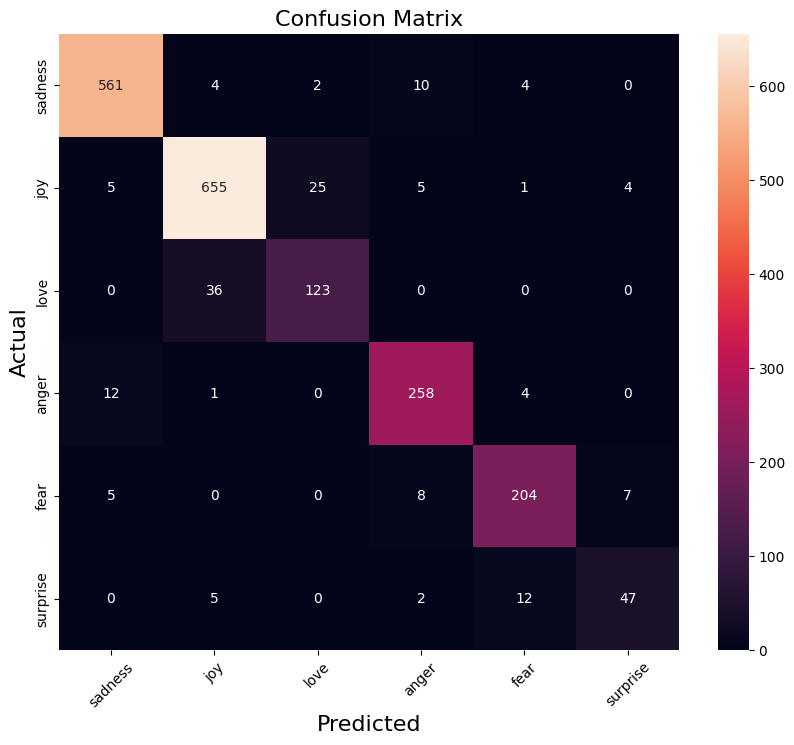

In [105]:
class_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(rotation=45)
plt.show()

In [106]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       581
           1       0.93      0.94      0.94       695
           2       0.82      0.77      0.80       159
           3       0.91      0.94      0.92       275
           4       0.91      0.91      0.91       224
           5       0.81      0.71      0.76        66

    accuracy                           0.92      2000
   macro avg       0.89      0.87      0.88      2000
weighted avg       0.92      0.92      0.92      2000



Convert Tensorflow model to tflite model

In [107]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter._experimental_lower_tensor_list_ops = False
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32
tflite_model = converter.convert()

In [108]:
len(tflite_model)

66931200

In [110]:
with open('model2.tflite', 'wb') as f:
    f.write(tflite_model)

In [112]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  4614      
                                                                 
 dropout_99 (Dropout)        multiple                  0         
                                                                 
Total params: 66958086 (255.42 MB)
Trainable params: 66958086 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [116]:
model.save("distilbertmodel.keras")